# General information
 * Author: Joris Busink, Junior Teacher Physics Education.
 * Date: Monday, 25th July.
 * About: Data processing script for high-speed camera. 

## Load packages
I load the following packages: numpy, matplotlib.pyplot, pandas. These pacakges are always usefull in doing nummerical calculations using Python. In a later stage, I will use the functions Curve_fit, fft, rfft and rfftfreq. I load these in as well.

In [45]:
# %matplotlib widget 
#requires package ipympl installed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import curve_fit
from scipy.fft import fft, rfft,rfftfreq
np.set_printoptions(precision=4,threshold =9,suppress=True)  #Compact display.

cwd = os.getcwd()
cwd= os.path.split(os.getcwd())[0]

## Read data
In this section we read in the raw data, furthermore, I do some small filtering in the data. 
<br>
### Necessary commands
 * Line 1: make dataframe 'df' that contains all data.<br>
 * Line 3-5: change the nummerical separator from a comma to a dot (In the Netherlands we use comma, international standard is a dot.)<br>
 * Line 6-7: remove "Not-a-Number", nan, values from the list.<br>

### Optional commands
* Line 8-10: make a subselection of the data. Handling large datafiles can be very slow and annoying. 
<br>


In [46]:
df=pd.read_csv(cwd+'/data/Slingerdata_1.mqa', sep='\t',header=0)
Time = df['Time'].str.replace(',', '.').astype(float).to_list()
Xpos = df['Point #1.X'].str.replace(',', '.').astype(float).to_list()
Ypos = df['Point #1.Y'].str.replace(',', '.').astype(float).to_list()
Xpos = [x for x in Xpos if str(x) != 'nan']
Ypos = [x for x in Ypos if str(x) != 'nan']
t=np.asarray(Time[:15000])
scaling = 1/1000 #scaling factor from pixel to [m]
x = np.asarray(Xpos[0:15000])*scaling 
y = np.asarray(Ypos[0:15000])*scaling 

## Plot data and apply fit to data
<p> In this section we plot the data. Furthermore, I define a model that should describe the data. The model is based on the small angle approximation $\theta<<1$ rad, in which the equation of motion of a simple pendulum is given by: </p>

$x(t) = A\sin(\omega_n t+\phi)+x_0$, with $\omega_n^2 =\frac{g}{l}$.<br>
<p>
A is the amplitude of the pendulum (in the x-direction), $\omega_n$ is the (normal) frequency of the pendulum. 
The frequency depends on the ratio of the gravitational acceleration g and the length of the cord l (the length from the center to the center of mass). $\phi$ is the phase of the oscillation and $x_0$ is the offset, the latter two parameters are arbitrary and a result of the experimental setting, not the experiment itself.</p>

### Necessary commands
 * Line 1-2: User defined model based on the theory. We vary the time coordinate (the independent variable, t) and the parameters a-d are determined by a fit. Note that the independent variable (t) must appear<em> before </em> the parameters, otherwise an errormessage will follow.<br>
 * Line 4-7: Apply a fit using the curve_fit function and print the result. Curve_fit asks for three input arguments (model, independent variable (t), dependent variable (x)), more input is optional. In this case, I provide an initial guess of the optimal parameters (p0). Other options include: weights, bounds, etc.<br>
 * Line 9-12: Plot the data (black) and the fit (darkred).<br>


 ### Optional commands
* Line 24-25: Save the figure at a location. Note that the figure is saved as a .svg extension. A .svg extension stands for Scalable Vector Image, the image is saved as an object (and not as a collection of pixels). One can import .svg picture in e.g. inkscape or adobe photoshop to manipulate these.
<br>



The optimal value for  Offset (pixel/100) is: 0.30 +- 0.00003
The optimal value for  Amplitude (pixel) is: 0.22 +- 0.00005
The optimal value for  Frequency (rad/s) is: 4.12 +- 0.00002
The optimal value for  phase (rad) is: 0.48 +- 0.00043


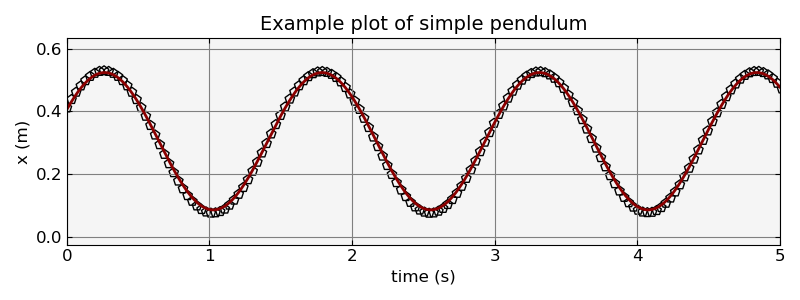

In [47]:
def model(t,a,b,c,d):
    return a+b*np.sin(c*t+d)

parameter=['Offset (pixel/100)', 'Amplitude (pixel)', 'Frequency (rad/s)', 'phase (rad)']
popt, pcov = curve_fit(model,t,x,p0=[0.3,0.23,4.12,0.5],bounds = ([0.1,0.2,2,0],[0.5,0.5,10,2*np.pi]))
for i in range (4):
    print("The optimal value for ", parameter[i], 'is:', "{:.2f}".format(popt[i]), '+-', "{:.5f}".format(np.sqrt(pcov[i,i])))
        
fig,axes=plt.subplots(1,1,figsize=(8,3),sharex=True,sharey=True)
axes.set_title('Example plot of simple pendulum',fontsize=14)
axes.scatter(t[::10],x[::10] ,color = 'black', s = 50, marker ='p',ec='black',fc='none') #plot every tenth datapoint [::10]
axes.plot(np.linspace(0,max(t),15001),model(np.linspace(0,max(t),15001),*popt), color ='darkred', lw = 2) #plot fit
axes.set_xlabel('time (s)',fontsize=12)
axes.set_ylabel('x (m)',fontsize=12)
axes.set_xlim(0,5)
axes.set_ylim(np.min(x)-0.1,np.max(x)+0.1)
axes.tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
axes.set_facecolor('whitesmoke')
axes.grid(True,color='gray')
plt.tight_layout() #creates optimal padding levels for figure (especially usefull for side-by-side figures)
plt.show()

# location='user_defined_location'
# plt.savefig('location'+'simple_pendulum.svg')

## Calculate derivative (nummerical & analytical)
<p>In the previous section we plotted the data of the simple pendulum. The data looks very smooth and we can described the data (very well) by a simple pendulum model. However, in most situations, we are not interested in the position of the object, but we are interested in the velocity or (even) the acceleration of an object. If one has an (analytica) function that describes the position as a function of time, we can simply derive the velocity or acceleration by taking the (second) derivative with respect to time. Therefore</p> 

 * $x(t) = A\sin(\omega_n t+\phi)+x_0$;<br>
 * $v(t) = \frac{dx(t)}{dt} = \omega_n A \cos(\omega_n+\phi)$;<br>
 * $a(t) = \frac{d^2x(t)}{dt^2} = -\omega_n^2 A \sin(\omega_n+\phi)$.<br>

<p> However, in most (realistic) (bio)mechanical systems, we do not have an analytical function that described the position as a function as time. Taking the derivative is therefore less trivial and we are forced to use nummerical methods. A straigthforward method is to calculate the derivative is to use <em>Euler</em> forward, backward or central method. The Euler central method works as following:<br>

 * $ f'(x) \approx \frac{f(x+h)-f(x-h)}{2h}$.<br> 
 
 An intuitive explanation is that we approximate the derivative by evaluating the function $f(x)$ at $f(x+h)$ and $f(x-h)$, with h the stepsize. Next, we take the difference of these expressions and divide by twice the stepsize. The smaller the stepsize we use, the better the approximation will be! Other (more advanced) methods to approximate a derivative of a function f(x) are based on higher-order derivatives. These methods are ofter more precise (or faster), but are cumbersome to implement.</p>

In Python, we can take the gradient function to calculate the derivative. It uses the Euler central method. Note that at the boundaries $t=t_0$ or $t=t_{final}$, the central method fails to work. However, the numpy gradient function switches to Euler forward/backward method to compensate for the loss of data at the edges.

The following links can provide some more information about the used methods.<br>
 * [Numpy Gradient function](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html)<br>
 * [Nummerical Differentiation using Python](https://personal.math.ubc.ca/~pwalls/math-python/differentiation/differentiation/
)

### Necessary commands
 * Line 1-2: I take the derivative of the position data with respect to time (line 1). In line 2 I take the second derivative, to obtain the acceleration.<br>
 * Line 4-12: I make a figure of 1 row and 3 collumns. I plot the x-t data (black pentagons) (panel 1) and model (solid line, darkred). In panel 2 and 3 I plot the velocity and acceleration versus time.<br>
 * Line 14-33: Some aesthetic aspects of the plot.<br>

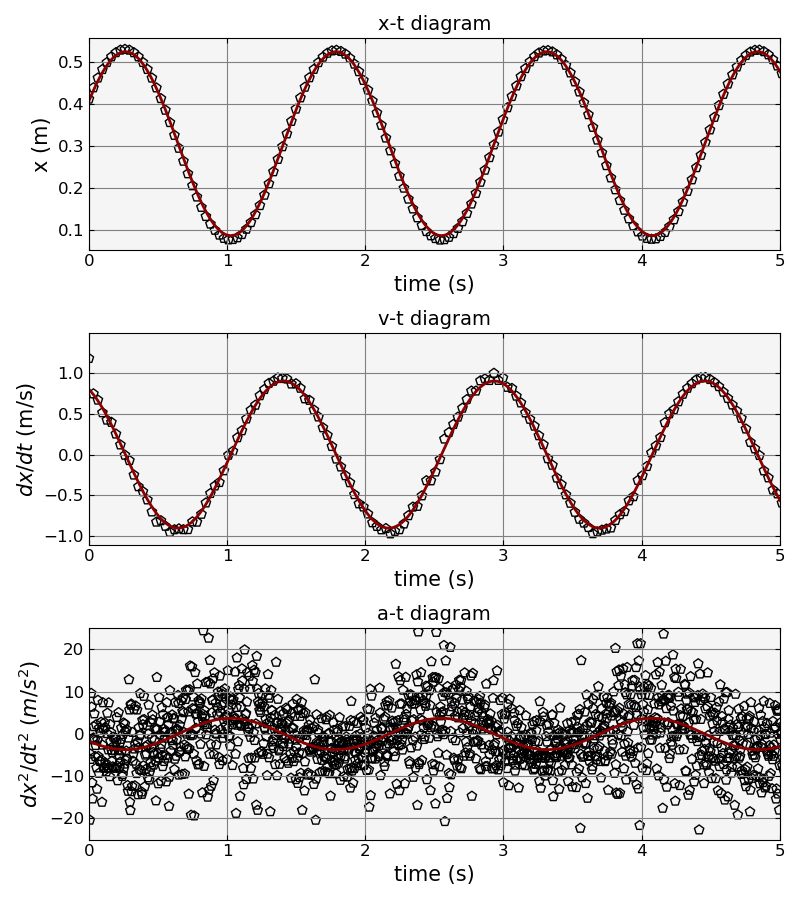

In [48]:
der1 = np.gradient(x,t)
der2 = np.gradient(der1,t)

fig,axes=plt.subplots(3,1,figsize=(8,9))
axes[0].scatter(t[::10],x[::10],color = 'black', s = 50, marker ='p',ec='black',fc='none') #plot every tenth datapoint [::10]
axes[0].plot(t,model(t,*popt),color='darkred',lw=2)

axes[1].scatter(t[::10], der1[::10], color='black', s = 50, marker ='p',ec='black',fc='none')
axes[1].plot(t,popt[2]*popt[1]*np.cos(popt[2]*t+popt[3]),color='darkred',lw=2)

axes[2].scatter(t[::], der2[::], color='black', s = 50, marker ='p',ec='black',fc='none')
axes[2].plot(t,-popt[2]**2*popt[1]*np.sin(popt[2]*t+popt[3]),color='darkred',lw=2)

axes[2].set_ylim(-25,25)
axes[0].set_title('x-t diagram',fontsize=14)
axes[1].set_title('v-t diagram',fontsize=14)
axes[2].set_title('a-t diagram',fontsize=14)

for i in range(3):
    axes[i].set_xlim(0,5)
    axes[i].set_xlabel('time (s)',fontsize=15)
    axes[i].tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
    axes[i].set_facecolor('whitesmoke')
    axes[i].grid(True,color='gray')

axes[0].set_ylabel('x (m)',fontsize=15)
axes[1].set_ylabel(r'$dx/dt$ (m/s)',fontsize=15)
axes[2].set_ylabel(r'$dx^2/dt^2$ $(m/s^2)$',fontsize=15)
plt.tight_layout()
plt.show()

# location='user_defined_location'
# plt.savefig('location'+'simple_pendulum.svg')

## Results
In the previous figure, we observe that x-t and v-t diagram still look reasonable. However, the a-t diagram is <em>very</em> chaotic. It is difficult to observe the expected (analytical) acceleration. Before we try to resolve this issue, we first have to understand it a bit better.<br>

The noisy data is a result of the method to calculate a derivative:
 * $ f'(x) \approx \frac{f(x+h)-f(x-h)}{2h}$.<br> 
 
 In our experiment, we use a high-speed camera, that produces (around) 500 fps. This means that we have a timestep of h = 1/fps = 0.002 seconds. Any observed difference in x(t) is magnified in the calculation of the velocity by $h^-1$ and even by $h^-2$ for the acceleration. This is in principle not a problem of the method, but of the finite resolution of the camera. If we would have an even faster acquistion rate (fps) we could in principle obscure single pixel differences between frames. The downside is that, between these frames the acceleration is $a=1$ $/h^2$ $[pixel/s^2]$. The acceleration that we obtain therefore depends on the resolution of the camera.  

 In practice, we also have to deal with noise, this makes the method to calculate a derivative even more problematic. To resolve these issues we can do methods: 
  * Decrease resolution of temporal data;
  * Apply a smoothing technique.

  Both methods decrease the resolution of the temporal data. In most experiments, this is not an issue.

### Method 1: Change temporal resolution (easy)
In this method we decrease the temporal resolution of the data. Instead of taking the derivative of each consequtive point, we calculate the derivative of each n-th consequtive point n $\in$ {1,2,3,4}. We therefore (effectively) smooth the data in between the data that we not use. This also implies that we could've decreased our acquisition rate by a factor n.

The downside of this method, is that we throw away a lot of data that couldbe potentially useful. 

### Necessary commands
 * line 2: define the n-th consequtive point.
 * line 7-10: decrease the resolution of the time and position data. Calculate the new velocities and acceleration.
 * line 11-12: plot nummerical and analytical derivative of the data.


0
1
2
3


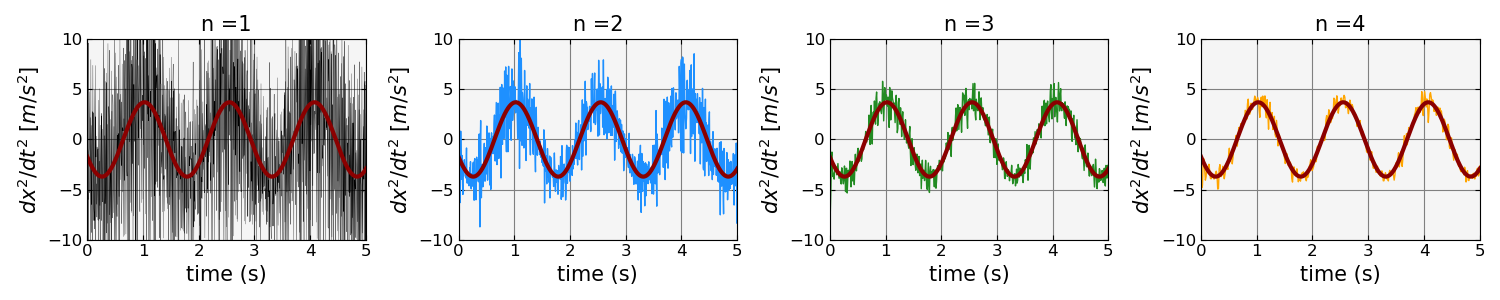

In [49]:
fig,axes=plt.subplots(1,4,figsize=(15,3))
slicelist= [1,2,3,4]
lwlist=[.2,1,1,1,1]
colorlist=['black','dodgerblue','forestgreen','orange','purple']
for i in range(len(slicelist)):
    print(i)
    x2 = x[::slicelist[i]]
    t2 = t[::slicelist[i]]
    der_slice1 = np.gradient(x2,t2)
    der_slice2 = np.gradient(der_slice1,t2)
    axes[i].plot(t2,der_slice2,color = colorlist[i],lw=lwlist[i])
    axes[i].plot(t,-popt[2]**2*popt[1]*np.sin(popt[2]*t+popt[3]),color='darkred',lw=3)
    
    axes[i].set_title("n =" + str(slicelist[i]),fontsize=15)
    axes[i].set_ylim(-10,10)
    axes[i].set_xlim(0,5)
    axes[i].set_xlabel('time (s)',fontsize=15)
    axes[i].tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
    axes[i].set_facecolor('whitesmoke')
    axes[i].grid(True,color='gray')
    axes[i].set_ylabel(r'$dx^2/dt^2$ $[m/s^2]$',fontsize=15)
plt.tight_layout()


### Method 2: Smoothing data (harder)
In this method we apply a smoothing technique to our data. Our starting point is the very noisy acceleration data. Instead of cropping the data, we can apply a smoothing technique: Savitzky-Golay filtering. The “savgol” filter is often used as a preprocessing in spectroscopy and signal processing. The filter can be used to reduce high frequency noise in a signal due to its smoothing properties and reduce low frequency signal (e.g., due to offsets and slopes) using differentiation [1]. 

**The Savitzky-Golay (savgol) Filter:**  <br>
For a given signal measured at N points and a filter of width, w, savgol calculates a polynomial fit of order o in each filter window as the filter is moved across the signal [1]. The result of this operation is a smoothened curve of the data. The downside is, just like the previous method, that the high-frequency components of the data are removed, i.e. a decrease in the resolution of the data [2].

 * [[1] Savitzky-Golay Smoothing and Differentiation Filter](https://eigenvector.com/wp-content/uploads/2020/01/SavitzkyGolay.pdf)<br>
 * [[2] Savitzky-Golay Smoothing Filters](http://phys.uri.edu/nigh/NumRec/bookfpdf/f14-8.pdf)<br>

### Necessary commands
 * line 1: impport savgol_filter
 * line 4: define the number of neighbours (width) of the filter. 

/var/folders/ft/6fwnv4852rd98wxqlgpt76680000gn/T/ipykernel_6284/2434048947.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axes=plt.subplots(1,4,figsize=(15,3))


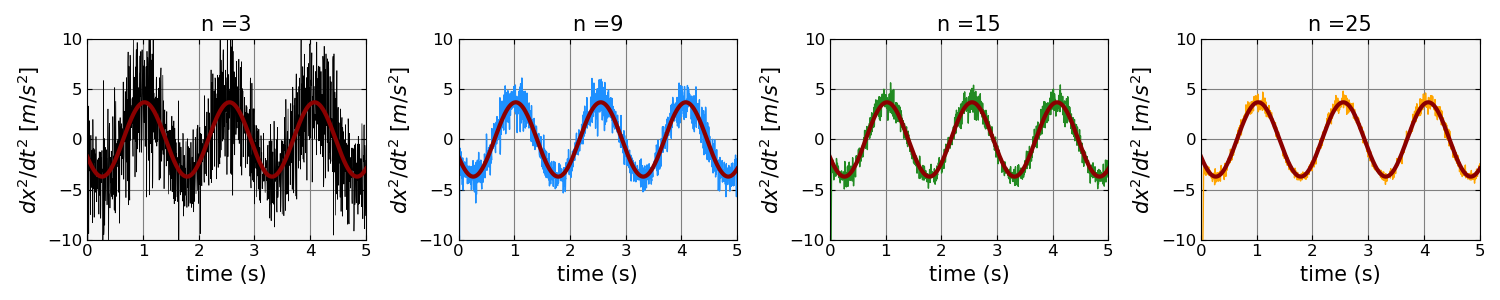

In [50]:
from scipy.signal import savgol_filter

fig,axes=plt.subplots(1,4,figsize=(15,3))
neighbourlist= [3,9,15,25]
lwlist=[.5,1,1,1,1]
colorlist=['black','dodgerblue','forestgreen','orange','purple']
for i in range(len(slicelist)):
    axes[i].plot(t, savgol_filter(der2,neighbourlist[i],1),color = colorlist[i],lw=lwlist[i])
    axes[i].plot(t,-popt[2]**2*popt[1]*np.sin(popt[2]*t+popt[3]),color='darkred',lw=3)
    axes[i].set_title("n =" + str(neighbourlist[i]),fontsize=15)
    axes[i].set_ylim(-10,10)
    axes[i].set_xlim(0,5)
    axes[i].set_xlabel('time (s)',fontsize=15)
    axes[i].tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
    axes[i].set_facecolor('whitesmoke')
    axes[i].grid(True,color='gray')
    axes[i].set_ylabel(r'$dx^2/dt^2$ $[m/s^2]$',fontsize=15)
plt.tight_layout()



## Discussion
In the previous two figures, we observe the same trend, as we increase the strength of the filtering, the nummerical acceleration $a^{w}_{obs}$ converges towards the analytical acceleration $a_{model}$ (based on a simple pendulum). The nummerical acceleration $a^{w}_{obs}$ depends on the window width, i.e. the savgol_filter width or the concatenated data method. 
I quantify the differences by calculating the mean squared difference between the analytical curve and the nummerical data:

$ \epsilon = \frac{1}{N}\sum_{n=1}^{n=N}(a^{w}_{obs}(t)-a_{model}(t))^2 .$

The value of $\epsilon$ is a measure of the deviation between the data and the model. This deviation is, in priniciple, a function of the window-width, and is therefore problem specific.

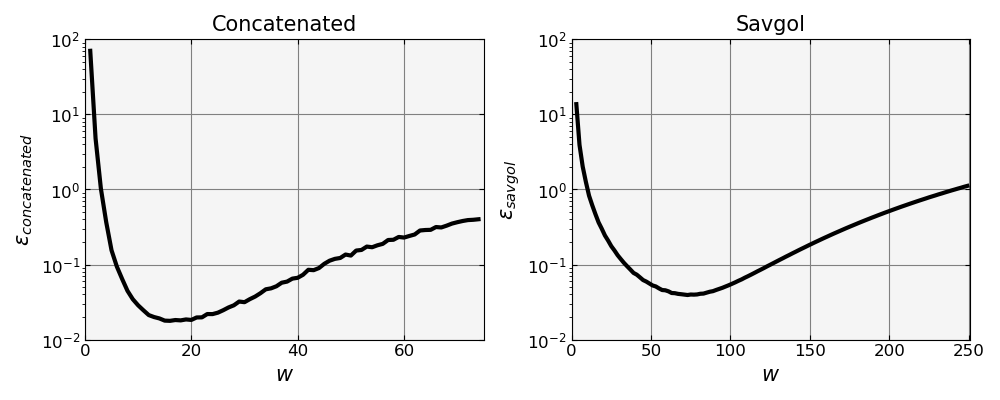

73
16


In [51]:
epsilon_concatenated,epsilon_savgol  = [],[]
for i in range(3,251,2):
    epsilon = 1/len(savgol_filter(der2,i,1))*np.sum((savgol_filter(der2,i,1)[i:] + popt[2]**2*popt[1]*np.sin(popt[2]*t[i:]+popt[3]))**2)
    epsilon_savgol.append(epsilon)
for j in range(1,75,1):
    x2,t2 = x[::j],t[::j]
    der_slice1 = np.gradient(x2,t2)
    der_slice2 = np.gradient(der_slice1,t2)
    epsilon_conc = 1/len(der_slice2)*np.sum((der_slice2[j:]+ popt[2]**2*popt[1]*np.sin(popt[2]*t2[j:]+popt[3]))**2)
    epsilon_concatenated.append(epsilon_conc)
    
fig,axes = plt.subplots(1,2,figsize=(10,4))
axes[0].set_title("Concatenated",fontsize=15)
axes[1].set_title("Savgol",fontsize=15)

axes[0].plot(np.arange(1,75,1),epsilon_concatenated, color ='black', lw=3)
axes[1].plot(np.arange(3,251,2),epsilon_savgol,color ='black',lw=3)

axes[0].set_xlim(0,75)
axes[1].set_xlim(0,251)
axes[0].set_ylabel(r'$\epsilon_{concatenated}$',fontsize=15)
axes[1].set_ylabel(r'$\epsilon_{savgol}$',fontsize=15)
for i in range(2):
    axes[i].set_xlabel('$w$',fontsize=15)
    axes[i].tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
    axes[i].set_facecolor('whitesmoke')
    axes[i].grid(True,color='gray')
    axes[i].set_ylim(0.01,100)
    axes[i].set_yscale('log')
plt.tight_layout()
plt.show()

print(np.arange(3,253,2)[np.argmin(epsilon_savgol)])
print(np.arange(1,75,1)[np.argmin(epsilon_concatenated)])

## Minimal error graphs

In the previous section, I calculated the optimal parameters for the Concatenated method and the Savgol method. Although the first method works slightly better, the savgol method also performs very well. In the next section I show the optimized nummerical acceleration on top of the analytical solution. 

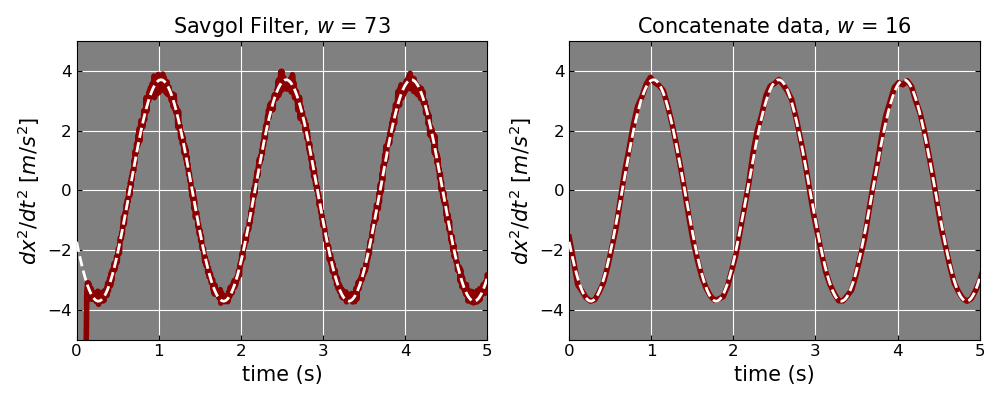

In [52]:
x_opt = x[::16]
t_opt = t[::16]
der_slice1 = np.gradient(x_opt,t_opt)
der_slice2 = np.gradient(der_slice1,t_opt)

fig,axes=plt.subplots(1,2,figsize=(10,4))
axes[0].plot(t, savgol_filter(der2,73,1),color = 'darkred',lw=4,zorder=2)
axes[0].plot(t,-popt[2]**2*popt[1]*np.sin(popt[2]*t+popt[3]),color='white',lw=2,zorder=3,ls='--')
axes[0].set_title('Savgol Filter, $w$ = 73',fontsize=15)
axes[1].plot(t_opt,der_slice2,color ='darkred',lw=4,zorder=2)
axes[1].plot(t,-popt[2]**2*popt[1]*np.sin(popt[2]*t+popt[3]),color='white',lw=2,zorder=3,ls='--')
axes[1].set_title('Concatenate data, $w$ = 16',fontsize=15)

for i in range(2):
    axes[i].set_ylim(-5,5)
    axes[i].set_xlim(0,5)
    axes[i].set_xlabel('time (s)',fontsize=15)
    axes[i].tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
    axes[i].set_facecolor('gray')
    axes[i].grid(True,color='white')
    axes[i].set_ylabel(r'$dx^2/dt^2$ $[m/s^2]$',fontsize=15)
plt.tight_layout()
plt.show()

## Data Kick

In the previous example, we had an analytical model. However, in most (bio)mechanical experiments, there's not an analytical model that describes the process of interest. In the next sections I will (quickly) go over the data of a kick. The data was, just as before, captures with a high-speed camera.

In [132]:
df=pd.read_csv(cwd+'/data/schop.csv', sep='\t',header=0)
Time = df['Time'].str.replace(',', '.').astype(float).to_list()
Angle = df['Angle #1'].str.replace(',', '.').astype(float).to_list()
Angle =np.asarray(Angle)*np.pi/180



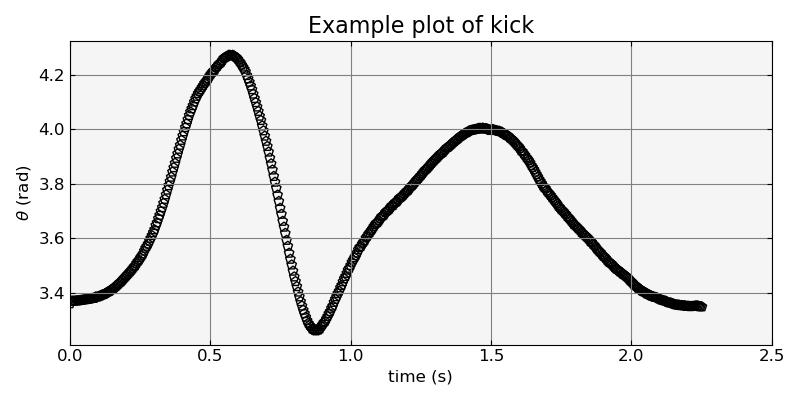

In [140]:
fig,axes=plt.subplots(1,1,figsize=(8,4))
axes.set_title('Example plot of kick',fontsize=16)
axes.scatter(Time,Angle ,color = 'black', s = 50, marker ='p',ec='black',fc='none') #plot every tenth datapoint [::10]
axes.set_xlabel('time (s)',fontsize=12)
axes.set_ylabel(r'$\theta$ (rad)',fontsize=12)
axes.set_xlim(0,2.5)
axes.tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
axes.set_facecolor('whitesmoke')
axes.grid(True,color='gray')
plt.tight_layout() #creates optimal padding levels for figure (especially usefull for side-by-side figures)
plt.show()

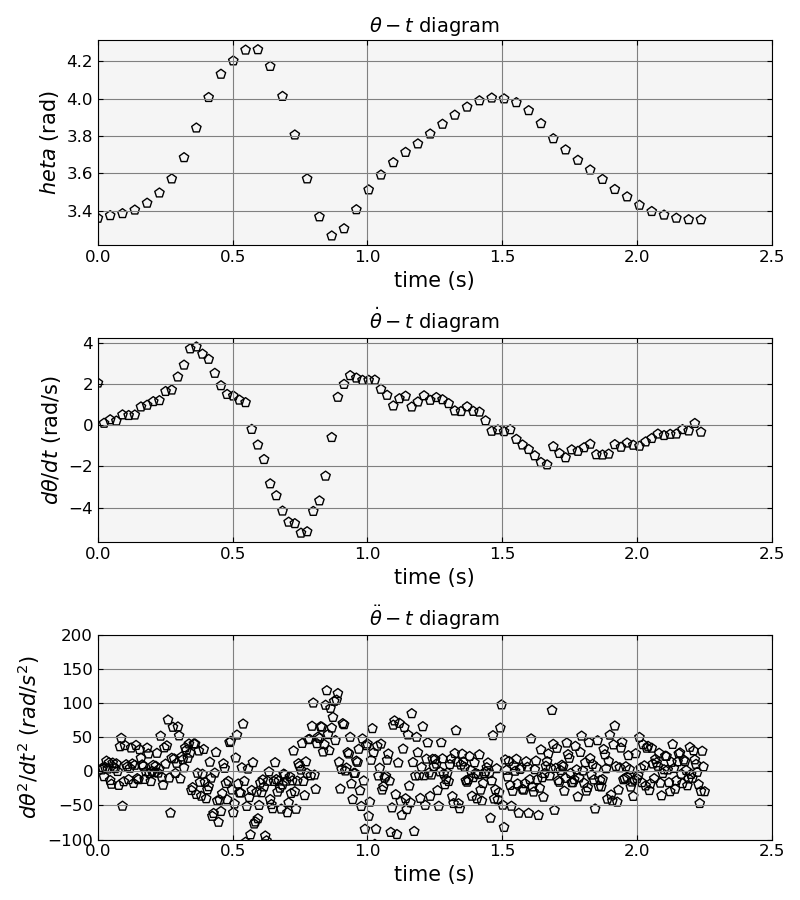

In [141]:
der1 = np.gradient(Angle,Time)
der2 = np.gradient(der1,Time)

fig,axes=plt.subplots(3,1,figsize=(8,9))
axes[0].scatter(Time[::10],Angle[::10],color = 'black', s = 50, marker ='p',ec='black',fc='none') #plot every tenth datapoint [::10]

axes[1].scatter(Time[::5], der1[::5], color='black', s = 50, marker ='p',ec='black',fc='none')

axes[2].scatter(Time[::], der2[::], color='black', s = 50, marker ='p',ec='black',fc='none')


axes[0].set_title(r'$\theta-t$ diagram',fontsize=14)
axes[1].set_title(r'$\dot{\theta}-t$ diagram',fontsize=14)
axes[2].set_title(r'$\ddot{\theta}-t$ diagram',fontsize=14)
axes[2].set_ylim(-100,200)
for i in range(3):
    axes[i].set_xlim(0,2.5)
    axes[i].set_xlabel('time (s)',fontsize=15)
    axes[i].tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
    axes[i].set_facecolor('whitesmoke')
    axes[i].grid(True,color='gray')

axes[0].set_ylabel('$\theta$ (rad)',fontsize=15)
axes[1].set_ylabel(r'$d\theta/dt$ (rad/s)',fontsize=15)
axes[2].set_ylabel(r'$d\theta^2/dt^2$ $(rad/s^2)$',fontsize=15)
plt.tight_layout()
plt.show()

# location='user_defined_location'
# plt.savefig('location'+'simple_pendulum.svg')

## Filtered data Kick

Just as before, we apply a filter to the data. However, we cannot use the same filtering window (w). During the analysis, the filtering window has to be checked manually. The optimal window width is always a trade-off between the resolution of the data and the details of the analysis. To make this analysis a little less subjective, one can lay the filtered data on top of the original data. 

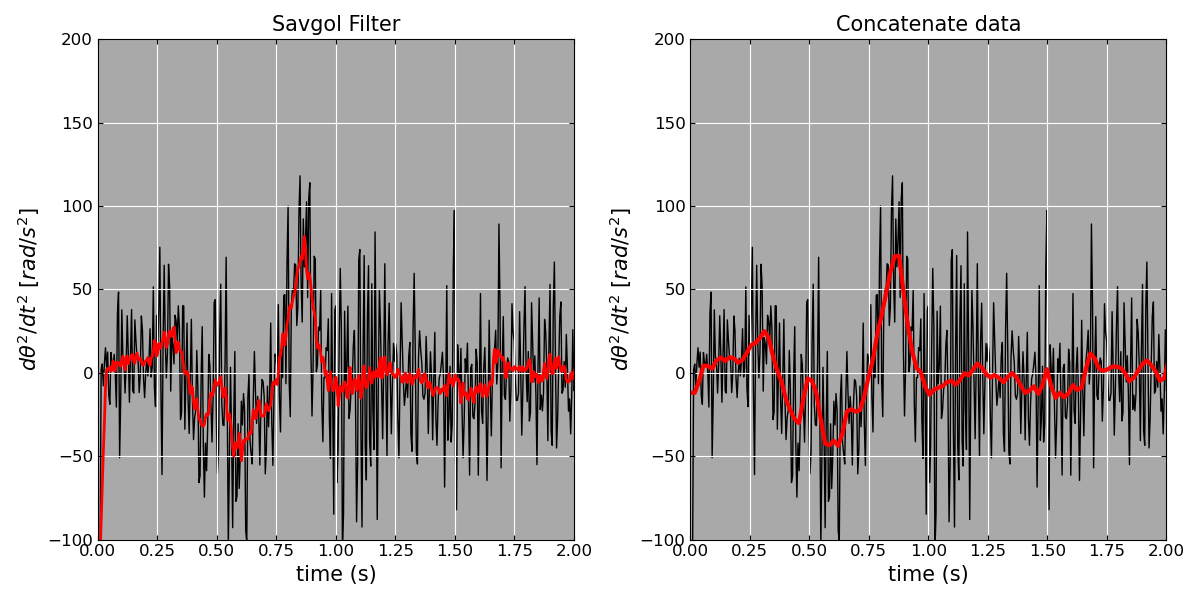

In [139]:
x_opt = Angle[::4]
t_opt = Time[::4]
der_slice1 = np.gradient(x_opt,t_opt)
der_slice2 = np.gradient(der_slice1,t_opt)

fig,axes=plt.subplots(1,2,figsize=(12,6))
axes[0].plot(Time, der2,color = 'black',lw=1,zorder=1)
axes[0].plot(Time, savgol_filter(der2,11,1),color = 'red',lw=2,zorder=2)
axes[0].set_title('Savgol Filter',fontsize=15)

axes[1].plot(t_opt,der_slice2,color ='red',lw=3,zorder=2)
axes[1].plot(Time, der2,color = 'black',lw=1,zorder=1)
axes[1].set_title('Concatenate data',fontsize=15)

for i in range(2):
    axes[i].set_ylim(-100,200)
    axes[i].set_xlim(0,2)
    axes[i].set_xlabel('time (s)',fontsize=15)
    axes[i].tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
    axes[i].set_ylabel(r'$d\theta^2/dt^2$ $[rad/s^2]$',fontsize=15)
    axes[i].set_facecolor('darkgray')
    axes[i].grid(True,color='white')


plt.tight_layout()
plt.show()